In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from cycifsuite.get_data import read_synapse_file
from cycifsuite.combat import combat
from cycifsuite.unsupervised_analysis import *

from umap import UMAP
from sklearn.decomposition import PCA

## Load data from Synapse and ComBat batch removal

In [2]:
path = 'N:/HiTS Projects and Data/Personal/Jake/mcf10a'
os.chdir(path)
expr_data = pd.read_hdf('postQC_log_normed_scaled_NC_ratio.hdf')
metadata = pd.read_csv('proper_FFC_metadata.csv',index_col=0)
metadata = metadata.loc[expr_data.index]

# Select columns
## Selecting only features with a marker and not later cycle DAPI
valid_cols = [x for x in expr_data.columns if 'none' not in x]
dna_cols = [x for x in expr_data.columns if 'dna_4' in x]
valid_cols = [x for x in valid_cols if 'dna_' not in x]
valid_cols = valid_cols + dna_cols
expr_data = expr_data[valid_cols]
# valid_cols = [x for x in valid_cols if 'background' not in x]

combat_norm_data = combat(expr_data.transpose(), metadata.replicate).transpose()
assert(combat_norm_data.notnull().all(axis=None))

found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


## Umap dimension reduction, will use previously save data if it exists.

In [3]:
umap_data_fn = 'unsupervised_analysis/umap_2d_expr_data_with_NC_ratio.csv'
if os.path.exists(umap_data_fn):
    umap_data=pd.read_csv(umap_data_fn,index_col=0)
else:
    pca = PCA(0.95)
    pca_data = pca.fit_transform(combat_norm_data[valid_cols])
    umap=UMAP(n_components=2)
    umap_data = umap.fit_transform(pca_data)
    umap_data = pd.DataFrame(umap_data, columns=['X1','X2'], index = combat_norm_data.index)
    umap_data['ligand'] = metadata.ligand
    umap_data['time'] = metadata.time
    umap_data = umap_data.sort_values('ligand')
    umap_data.to_csv(umap_data_fn)
umap_data = umap_data.merge(metadata[['replicate']],left_index=True,right_index=True, how='left')

## Plotting single cell data on UMAP space with colors mapped to ligand, time and replicates.
### This is also Figure 8 in the method document.

(<matplotlib.legend.Legend at 0x2b5b90e2e48>, Text(0, 0.5, 'UMAP2'))

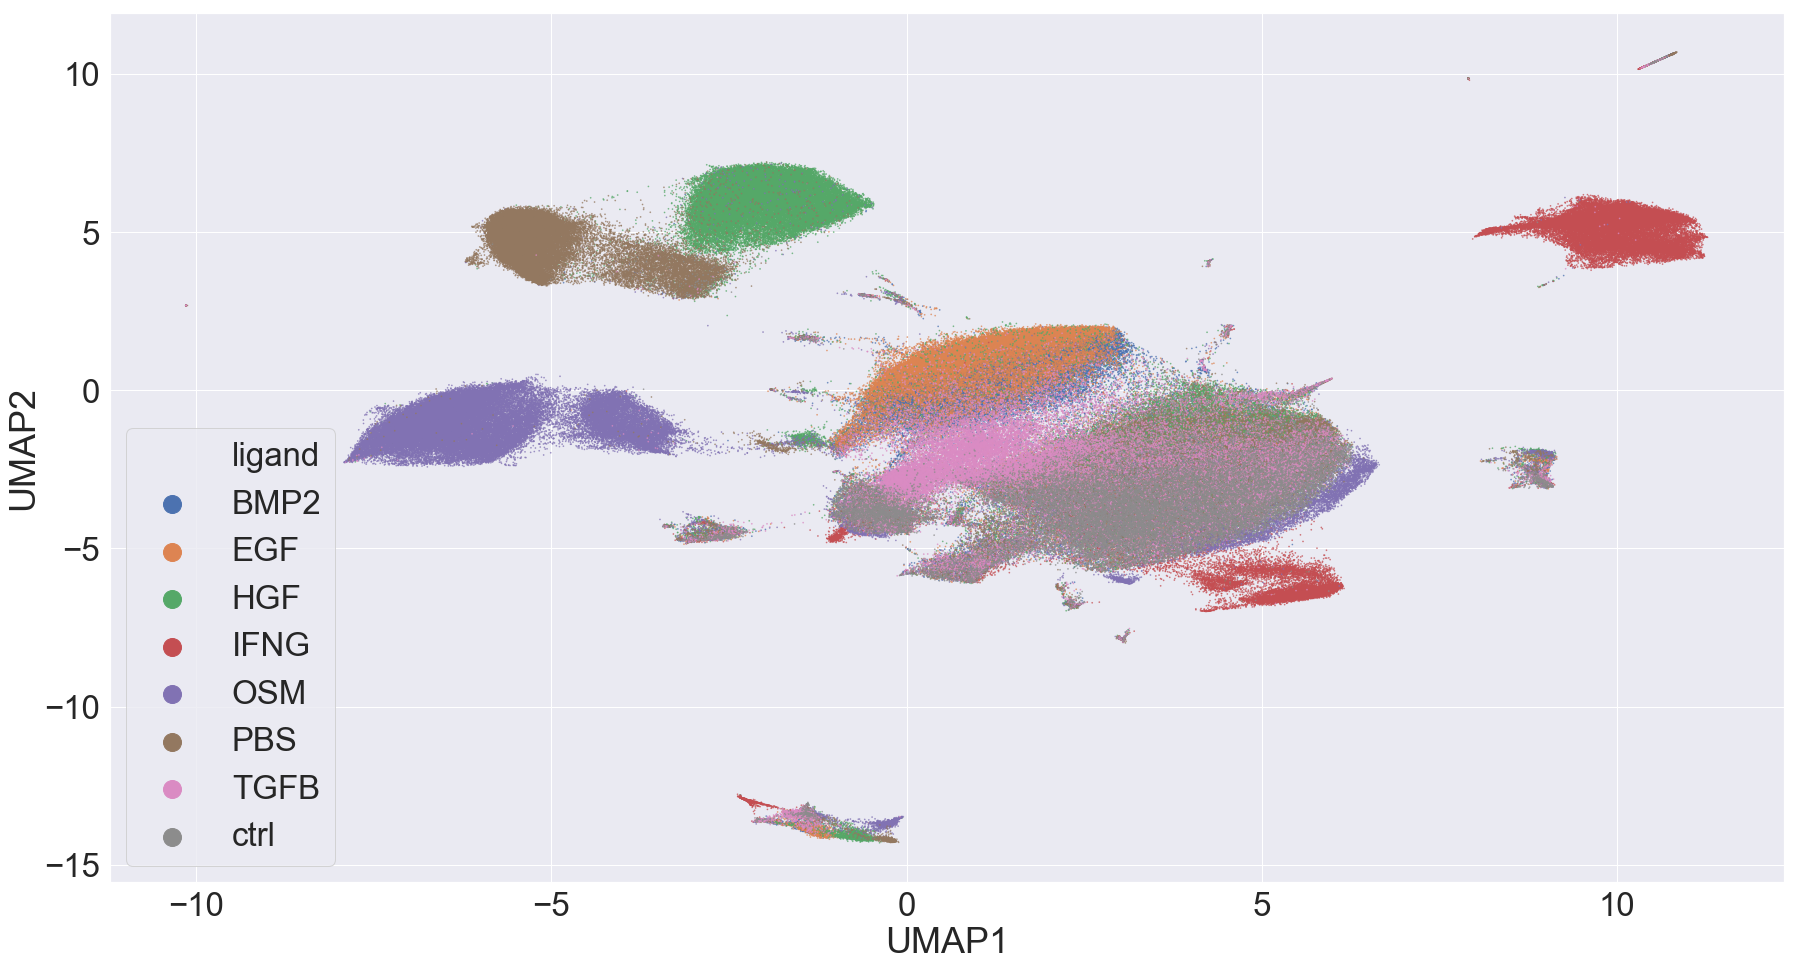

In [25]:
sns.set(font_scale=3)
plt.figure(figsize=(30,16))
_ = sns.scatterplot('X1','X2',data=umap_data, hue='ligand', s=1, legend='full', edgecolor=None, alpha = 0.6)
_ = plt.legend(markerscale=3)
_, plt.xlabel('UMAP1')
_, plt.ylabel('UMAP2')

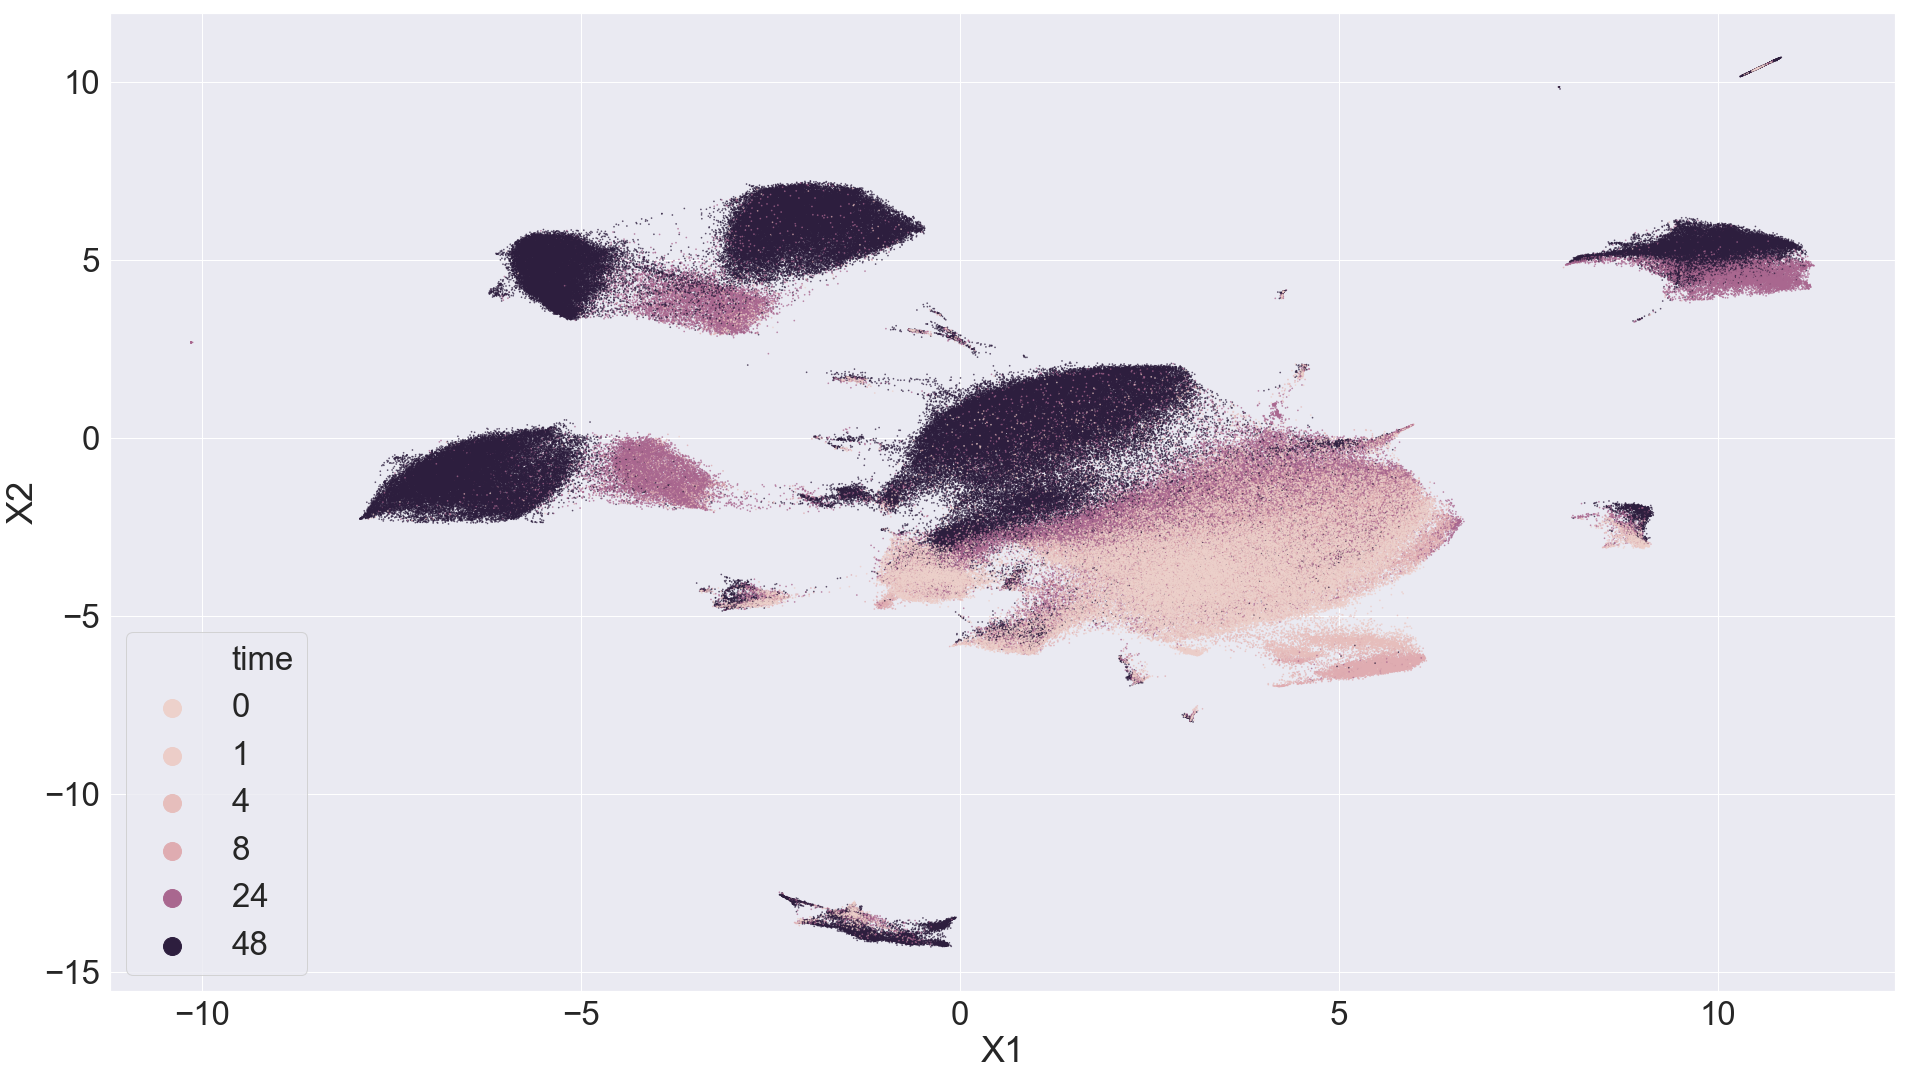

In [50]:
sns.set(font_scale=3)
plt.figure(figsize=(32,18))
sns.scatterplot('X1','X2',data=umap_data, hue='time', s=1, legend='full', edgecolor=None, alpha = 0.6)
plt.legend(markerscale=3)

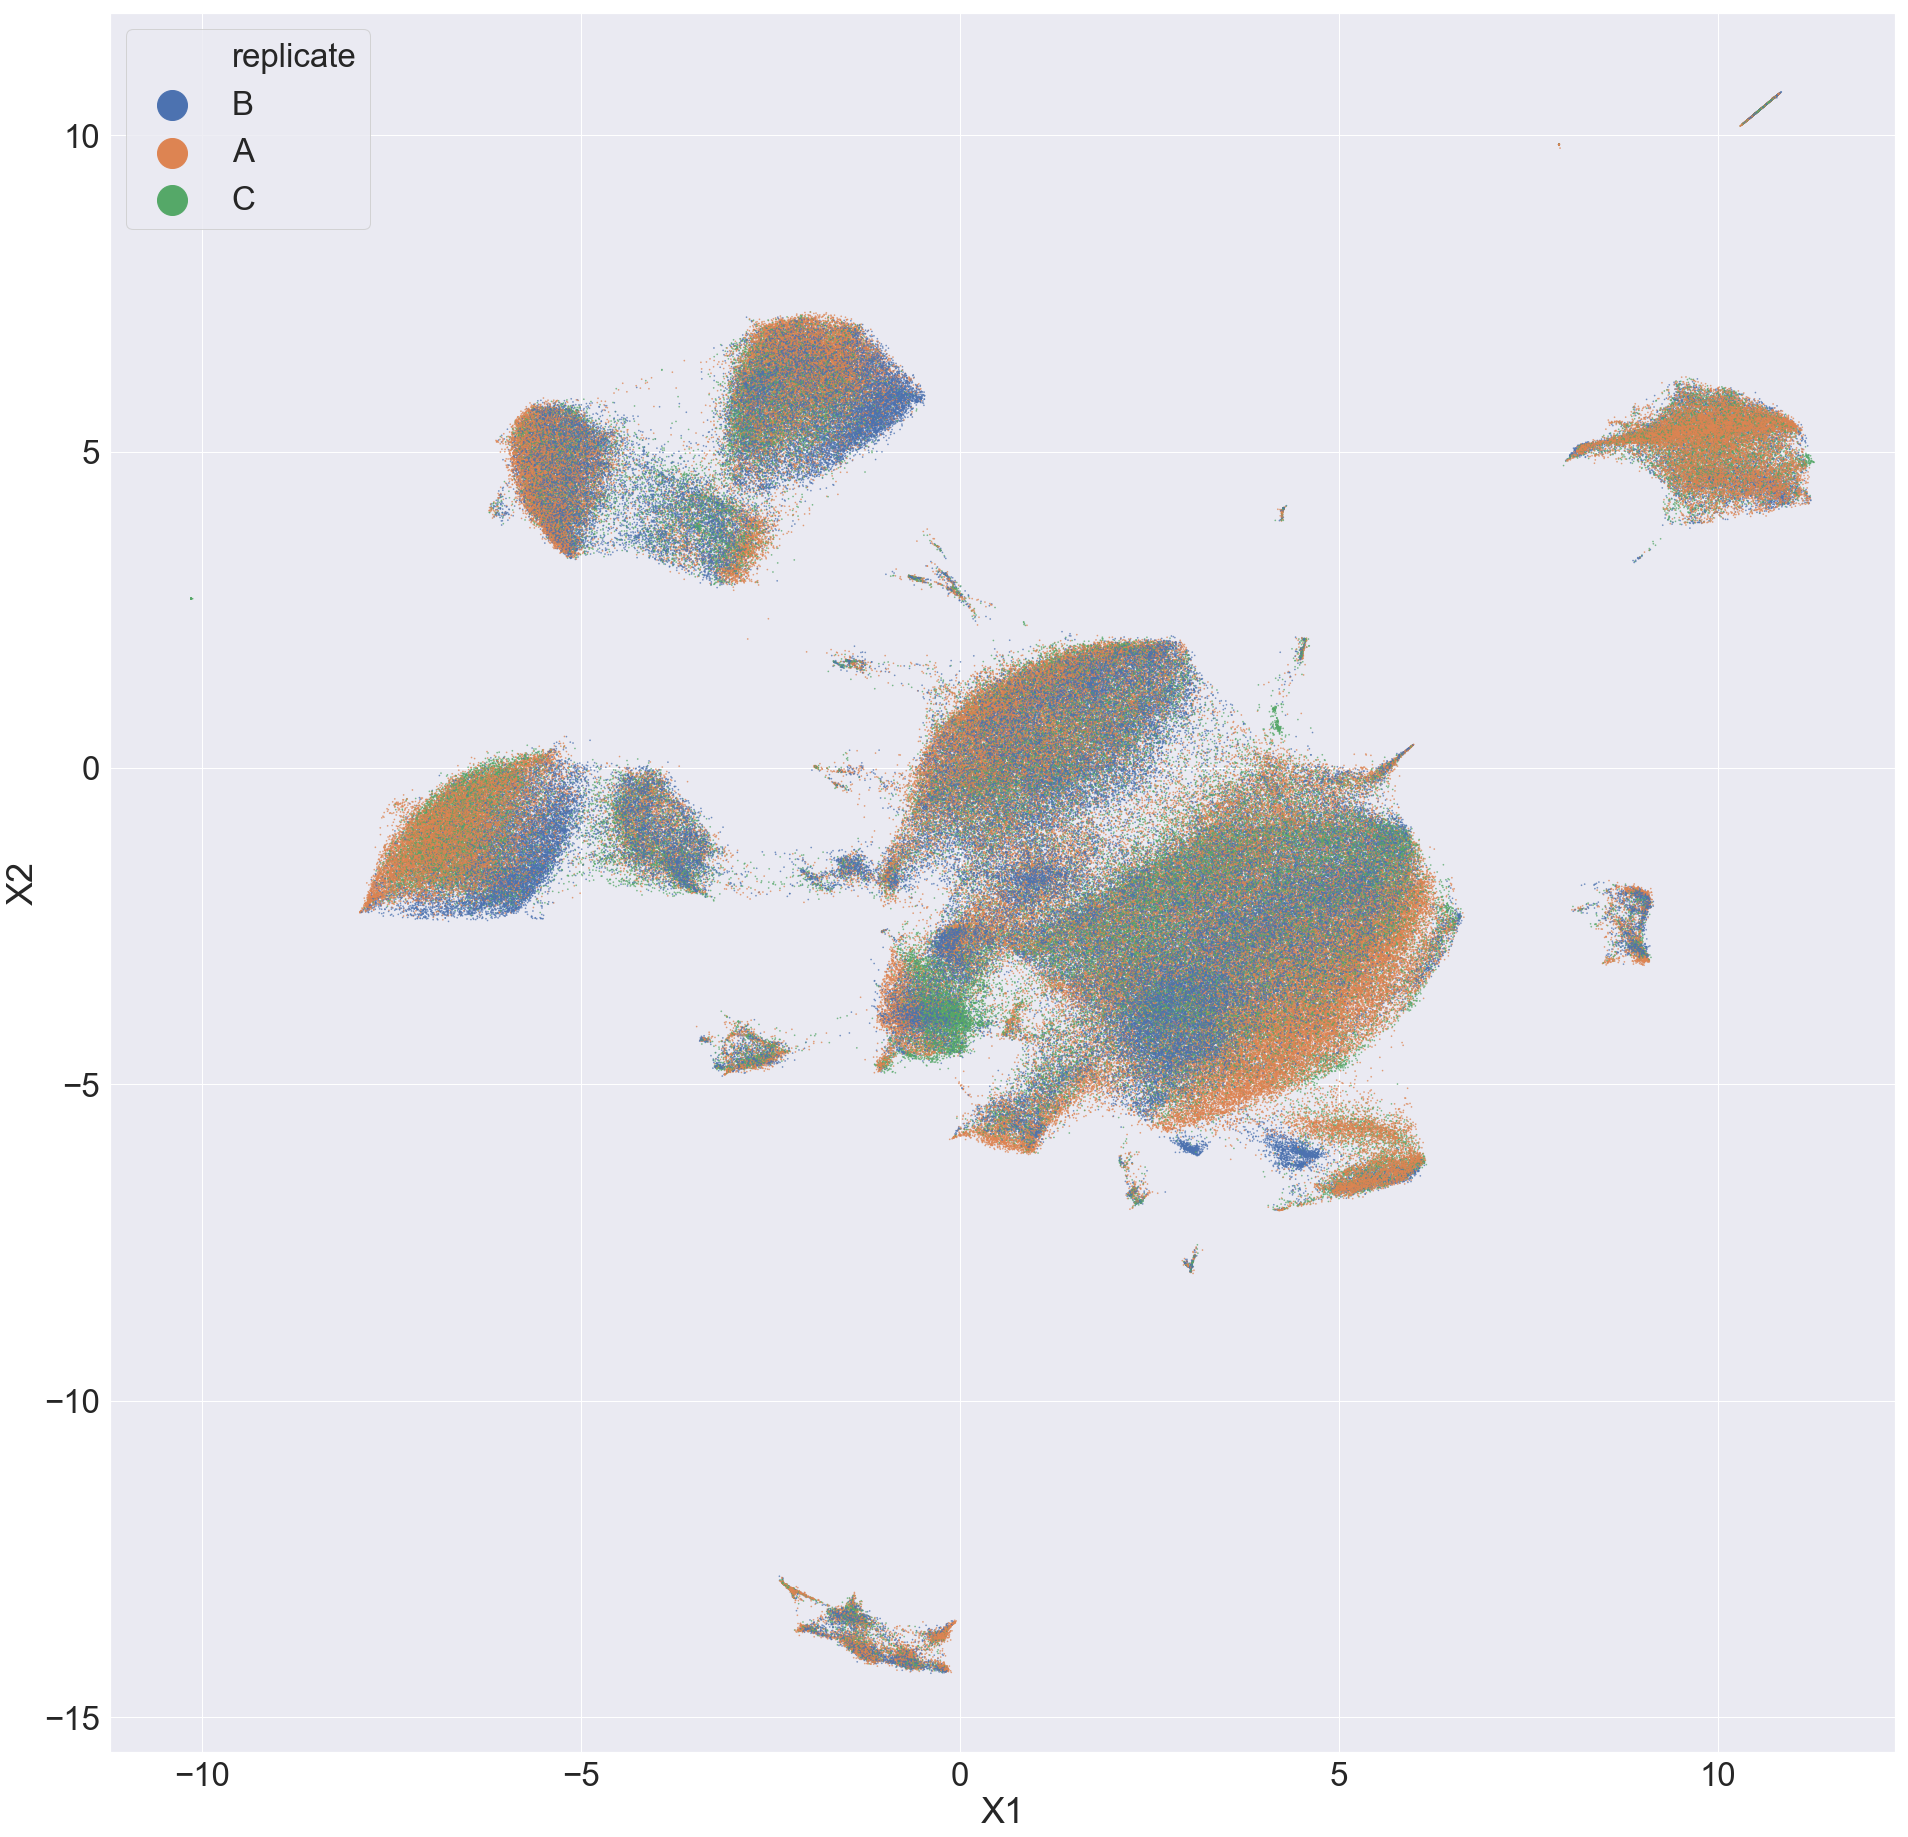

In [10]:
plt.figure(figsize=(32,32))
sns.scatterplot('X1','X2',data=umap_data, hue='replicate', s=1, legend='full', edgecolor = None, alpha=0.6)
plt.legend(markerscale=5)

## HDBSCAN clustering
Note: a random seed is used

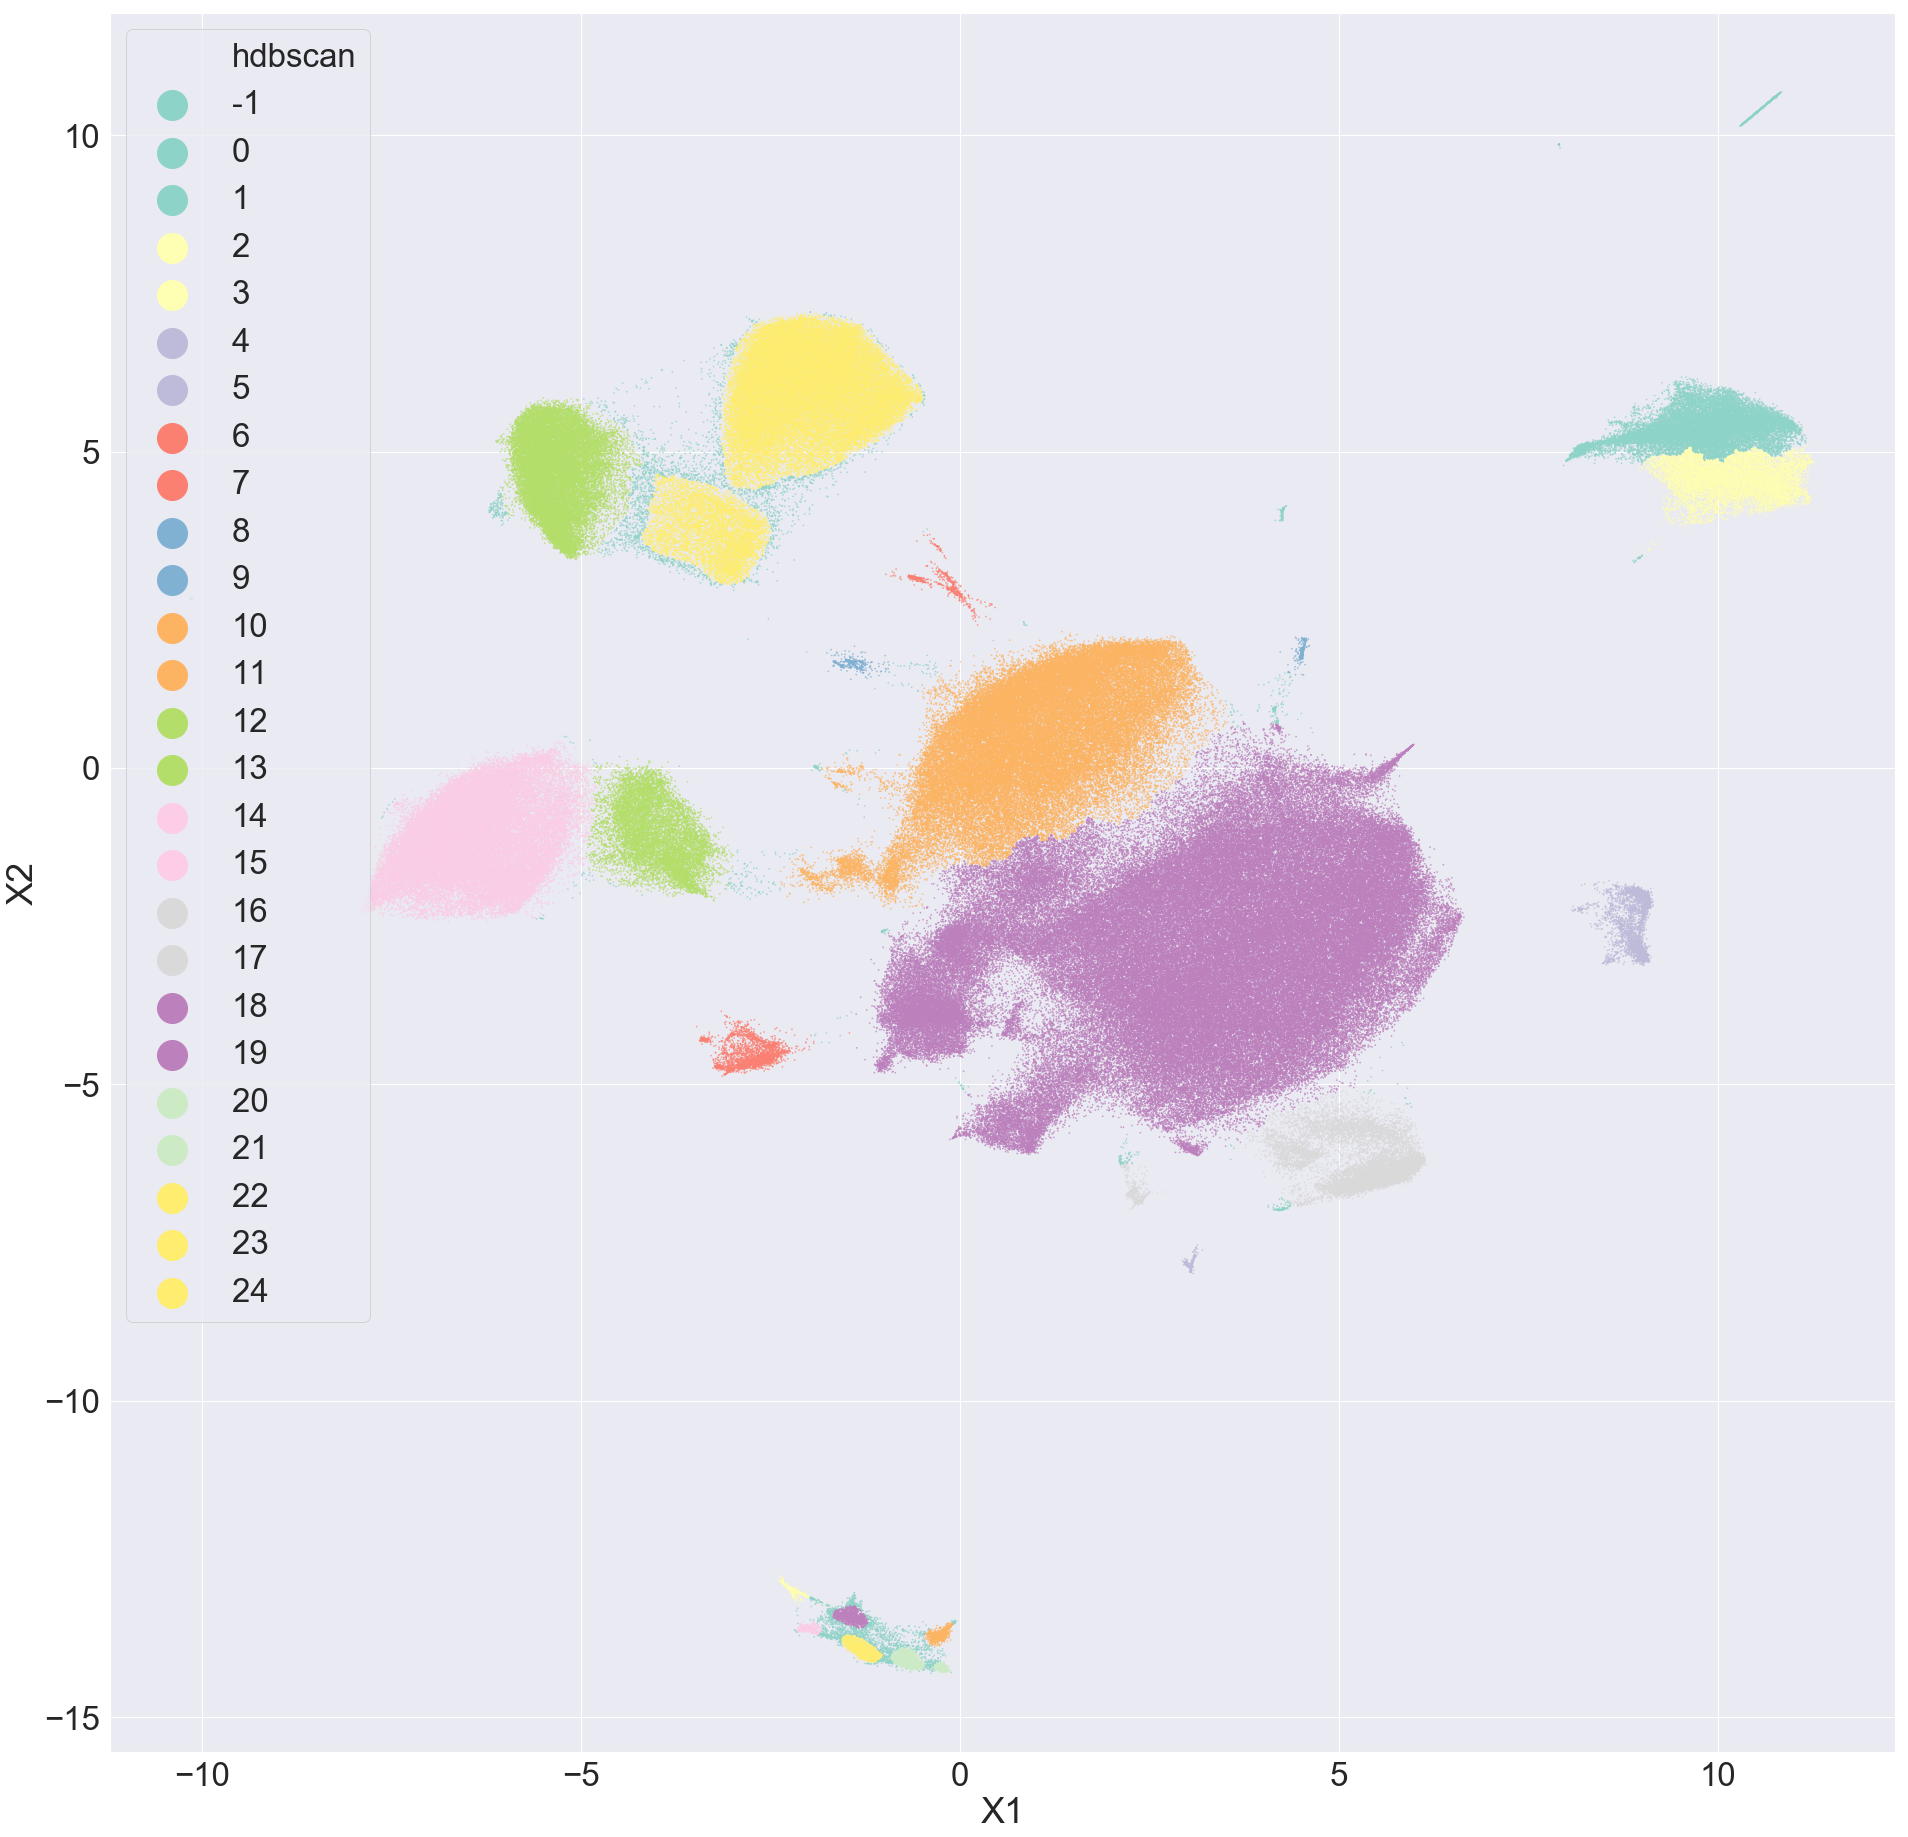

In [26]:
from hdbscan import HDBSCAN
np.random.seed(999)
cluster_estimator = HDBSCAN(min_cluster_size=250,min_samples=250, memory='d:/data/')
labels = cluster_estimator.fit_predict(umap_data.iloc[:,:2])
umap_data['hdbscan'] = labels
sns.set(font_scale=3)
plt.figure(figsize=(32,32))
sns.scatterplot('X1','X2',data=umap_data, hue='hdbscan',legend='full',palette='Set3', edgecolor=None, s=1, alpha=0.6)
plt.legend(markerscale=5)
# plt.savefig('umap_hdbscan.png')

## Evaluating cluster composition.
#### Note: Cluster -1, 2, 3, 7, 16 was dropped due to its very small size and highly mixed nature

In [28]:
umap_data['cond'] = umap_data.ligand + '_' + umap_data.time.astype(str)
cluster_comp = umap_data.groupby(['hdbscan', 'cond']).count().X1/umap_data.groupby('hdbscan').count().X1
clusters = umap_data.hdbscan.copy()
clusters = clusters[~clusters.isin([-1,4,5,6,7,8,9,15,16,19])]
for cluster in sorted(clusters.unique()):
    top_3 = cluster_comp.loc[cluster].sort_values(ascending=False)[:3]
    print(cluster, ', '.join(top_3.index), ' : ', ', '.join(top_3.values.round(2).astype(str)))
    if cluster != -1:
        clusters[clusters == cluster] = '_'.join(top_3.index[:3]) + '({:.2f}) C_{}'.format(top_3.sum(), str(cluster))
        
cluster_sizes = pd.DataFrame(clusters.groupby(clusters).count()/clusters.shape[0] * 100).round(1)
cluster_sizes.loc[:, 'new_name'] = cluster_sizes.iloc[:,0].astype(str) + '%_' + cluster_sizes.index.astype(str)
print(cluster_sizes.new_name)
clusters[:] = cluster_sizes.loc[clusters.values,'new_name'].values

0 HGF_48, EGF_48, BMP2_48  :  0.24, 0.16, 0.11
1 IFNG_48, IFNG_24, IFNG_8  :  0.91, 0.09, 0.0
2 IFNG_24, IFNG_48, IFNG_8  :  0.81, 0.18, 0.01
3 IFNG_48, IFNG_24, IFNG_8  :  0.81, 0.15, 0.03
10 EGF_48, BMP2_48, TGFB_48  :  0.45, 0.44, 0.05
11 OSM_48, OSM_24, PBS_48  :  0.99, 0.0, 0.0
12 PBS_48, PBS_24, HGF_48  :  0.95, 0.03, 0.01
13 OSM_24, OSM_8, OSM_48  :  0.85, 0.09, 0.03
14 OSM_48, OSM_24, HGF_48  :  0.98, 0.02, 0.0
17 IFNG_8, IFNG_4, IFNG_1  :  0.59, 0.35, 0.05
18 ctrl_0, TGFB_48, BMP2_24  :  0.15, 0.07, 0.06
20 PBS_48, PBS_24, HGF_48  :  0.97, 0.02, 0.01
21 HGF_48, PBS_24, EGF_48  :  0.96, 0.01, 0.01
22 EGF_48, BMP2_48, TGFB_48  :  0.55, 0.35, 0.04
23 PBS_24, PBS_48, PBS_8  :  0.74, 0.08, 0.05
24 HGF_48, PBS_24, PBS_48  :  0.98, 0.01, 0.0
hdbscan
EGF_48_BMP2_48_TGFB_48(0.93) C_10    15.7%_EGF_48_BMP2_48_TGFB_48(0.93) C_10
EGF_48_BMP2_48_TGFB_48(0.94) C_22     0.5%_EGF_48_BMP2_48_TGFB_48(0.94) C_22
HGF_48_EGF_48_BMP2_48(0.51) C_0         0.6%_HGF_48_EGF_48_BMP2_48(0.51) C_0
HGF_48_

## Only the kept clusters

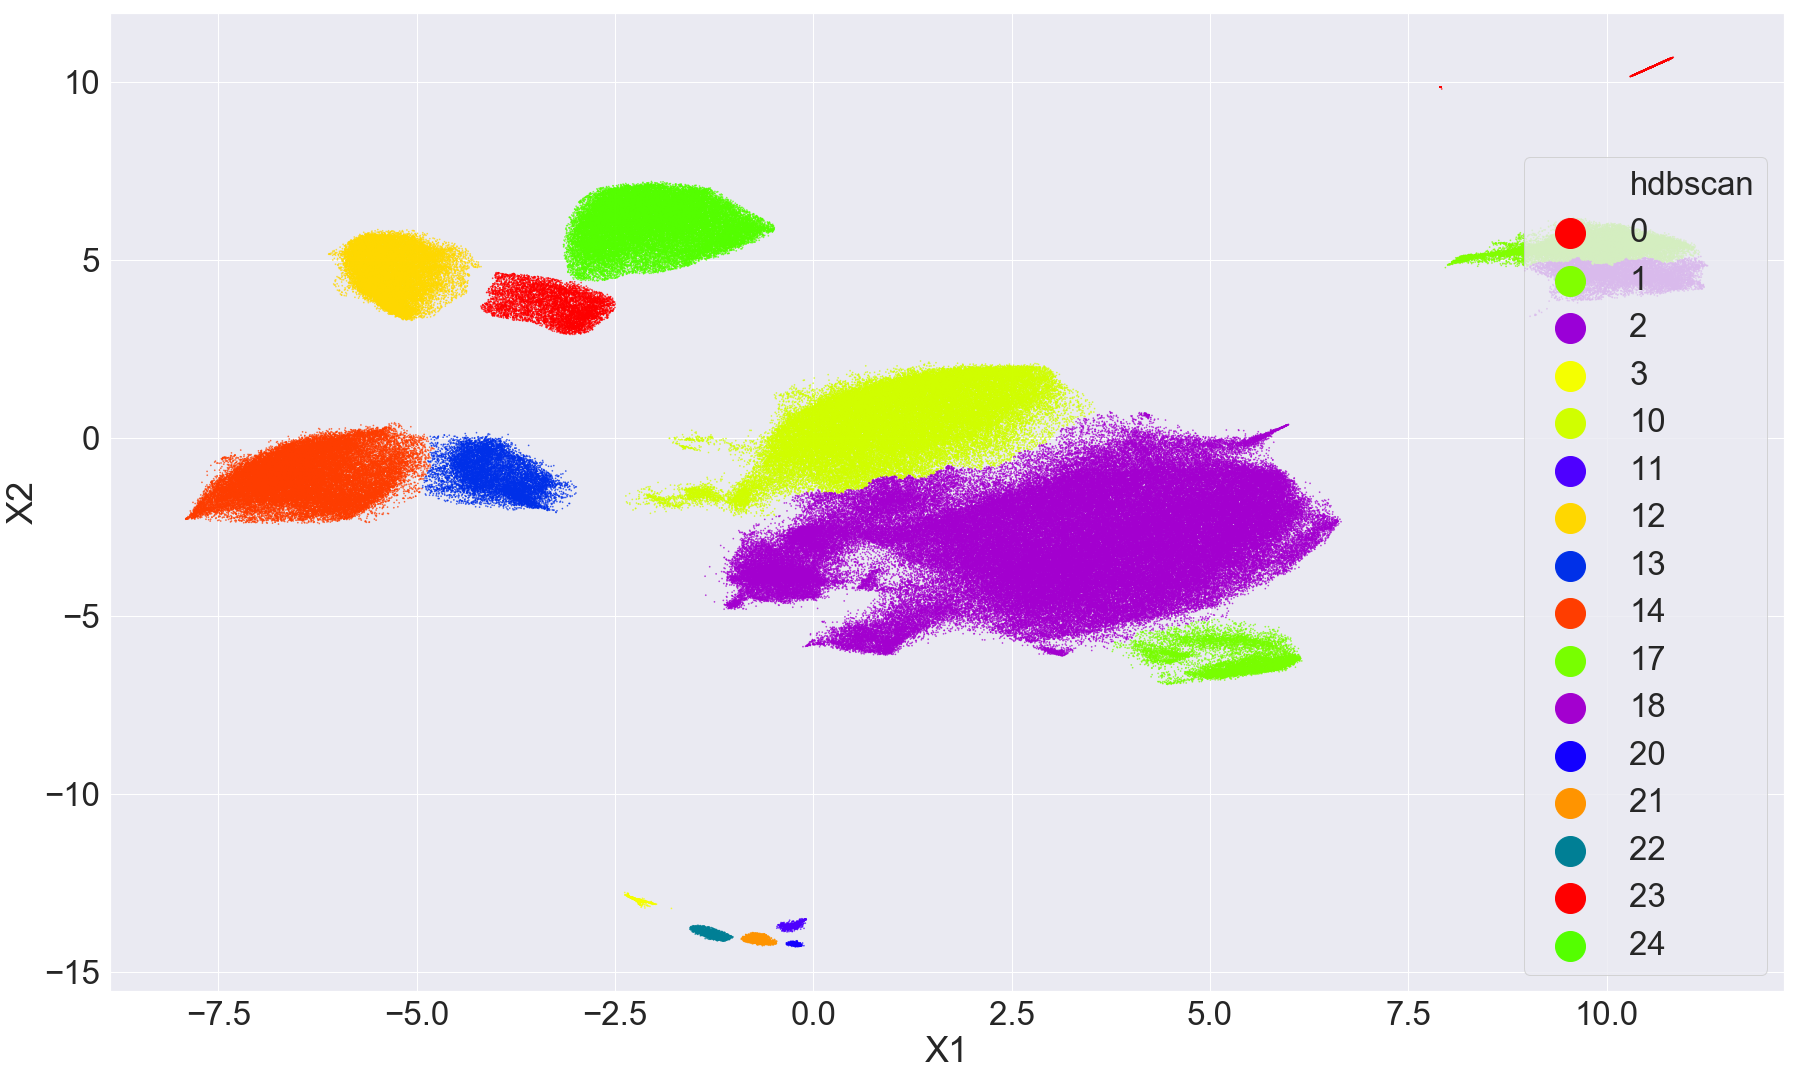

In [49]:
sns.set(font_scale=3)
plt.figure(figsize=(30,18))
sns.scatterplot('X1','X2',data=umap_data[~umap_data.hdbscan.isin([-1,4,5,6,7,8,9,15,16,19])], hue='hdbscan',legend='full',palette='prism', edgecolor=None, s=1, alpha=0.6)
plt.legend(markerscale=5)

## Downstream analysis and differential analysis
### Get top upregulated genes in each cluster

In [33]:
from cycifsuite.common_apis import differential_analysis
report = pd.DataFrame()
for cluster in clusters.unique():
    query = clusters[clusters==cluster].index
    ref = clusters[clusters!=cluster].index
    _cluster_report = pd.DataFrame(combat_norm_data.loc[query, valid_cols].mean() - combat_norm_data.loc[ref,valid_cols].mean())
    _cluster_report['cluster'] = '_'.join(['cluster',str(cluster)])
    report = report.append(_cluster_report)

report.columns = ['logFC', 'cluster']
report['absFC'] = np.abs(report.logFC)
report = report.sort_values('absFC', ascending=False)
top_genes = report.groupby('cluster').head(3).index.unique()

## Plotting
### Correlation heatmap of top genes

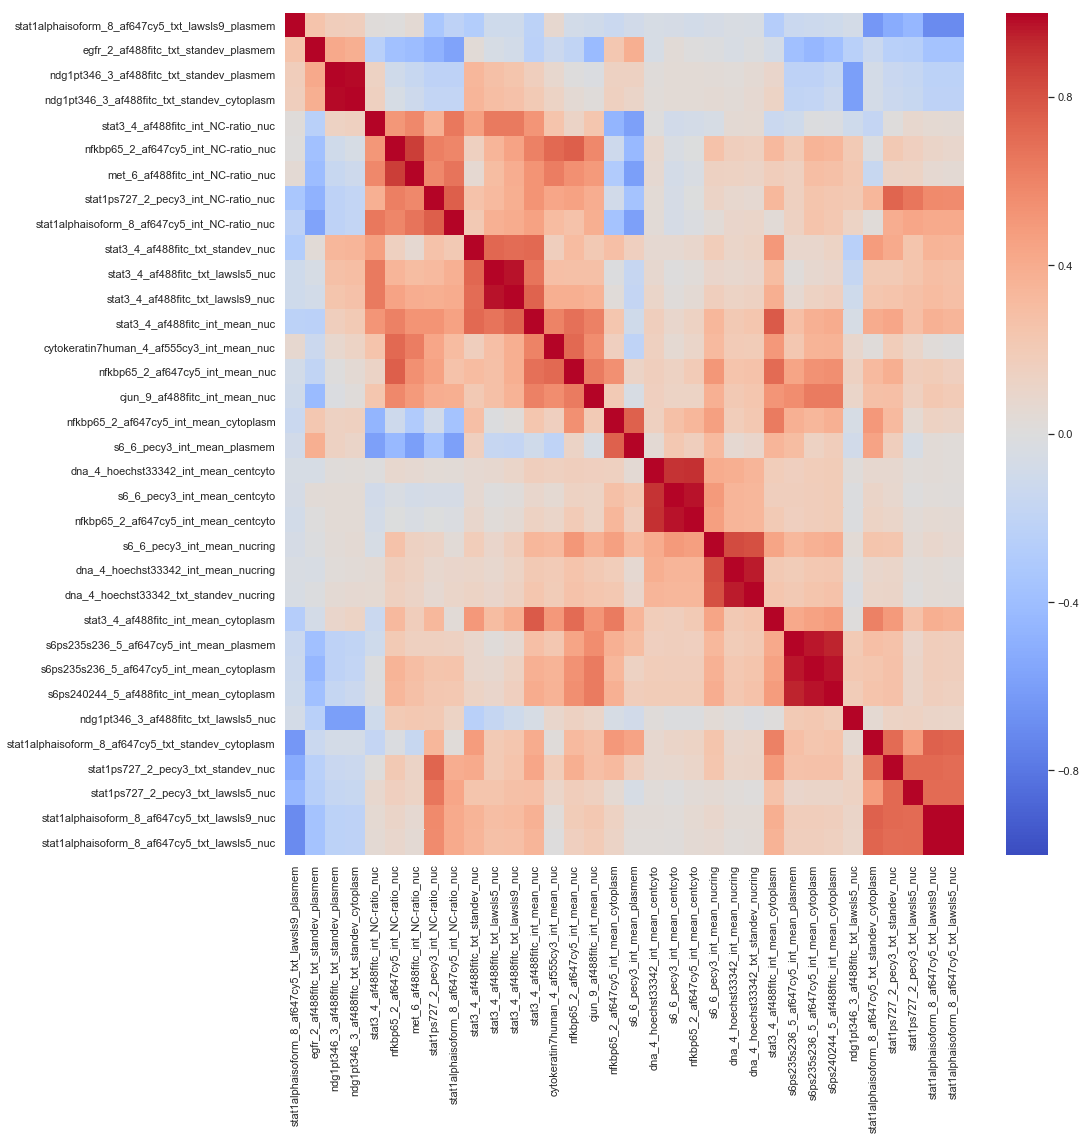

In [34]:
from cycifsuite.common_apis import two_way_hc_ordering
sns.set(font_scale=1)
marker_cor = combat_norm_data[top_genes].corr()
r_o, c_o = two_way_hc_ordering(marker_cor)
plt.figure(figsize=(16,16))
sns.heatmap(marker_cor.iloc[r_o,c_o], cmap='coolwarm', vmin=-1, vmax=1)
plt.tight_layout()
# plt.savefig('top_DE_genes_corr.png')

## Gene expression pattern in clusters

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <a list of 33 Text xticklabel objects>)

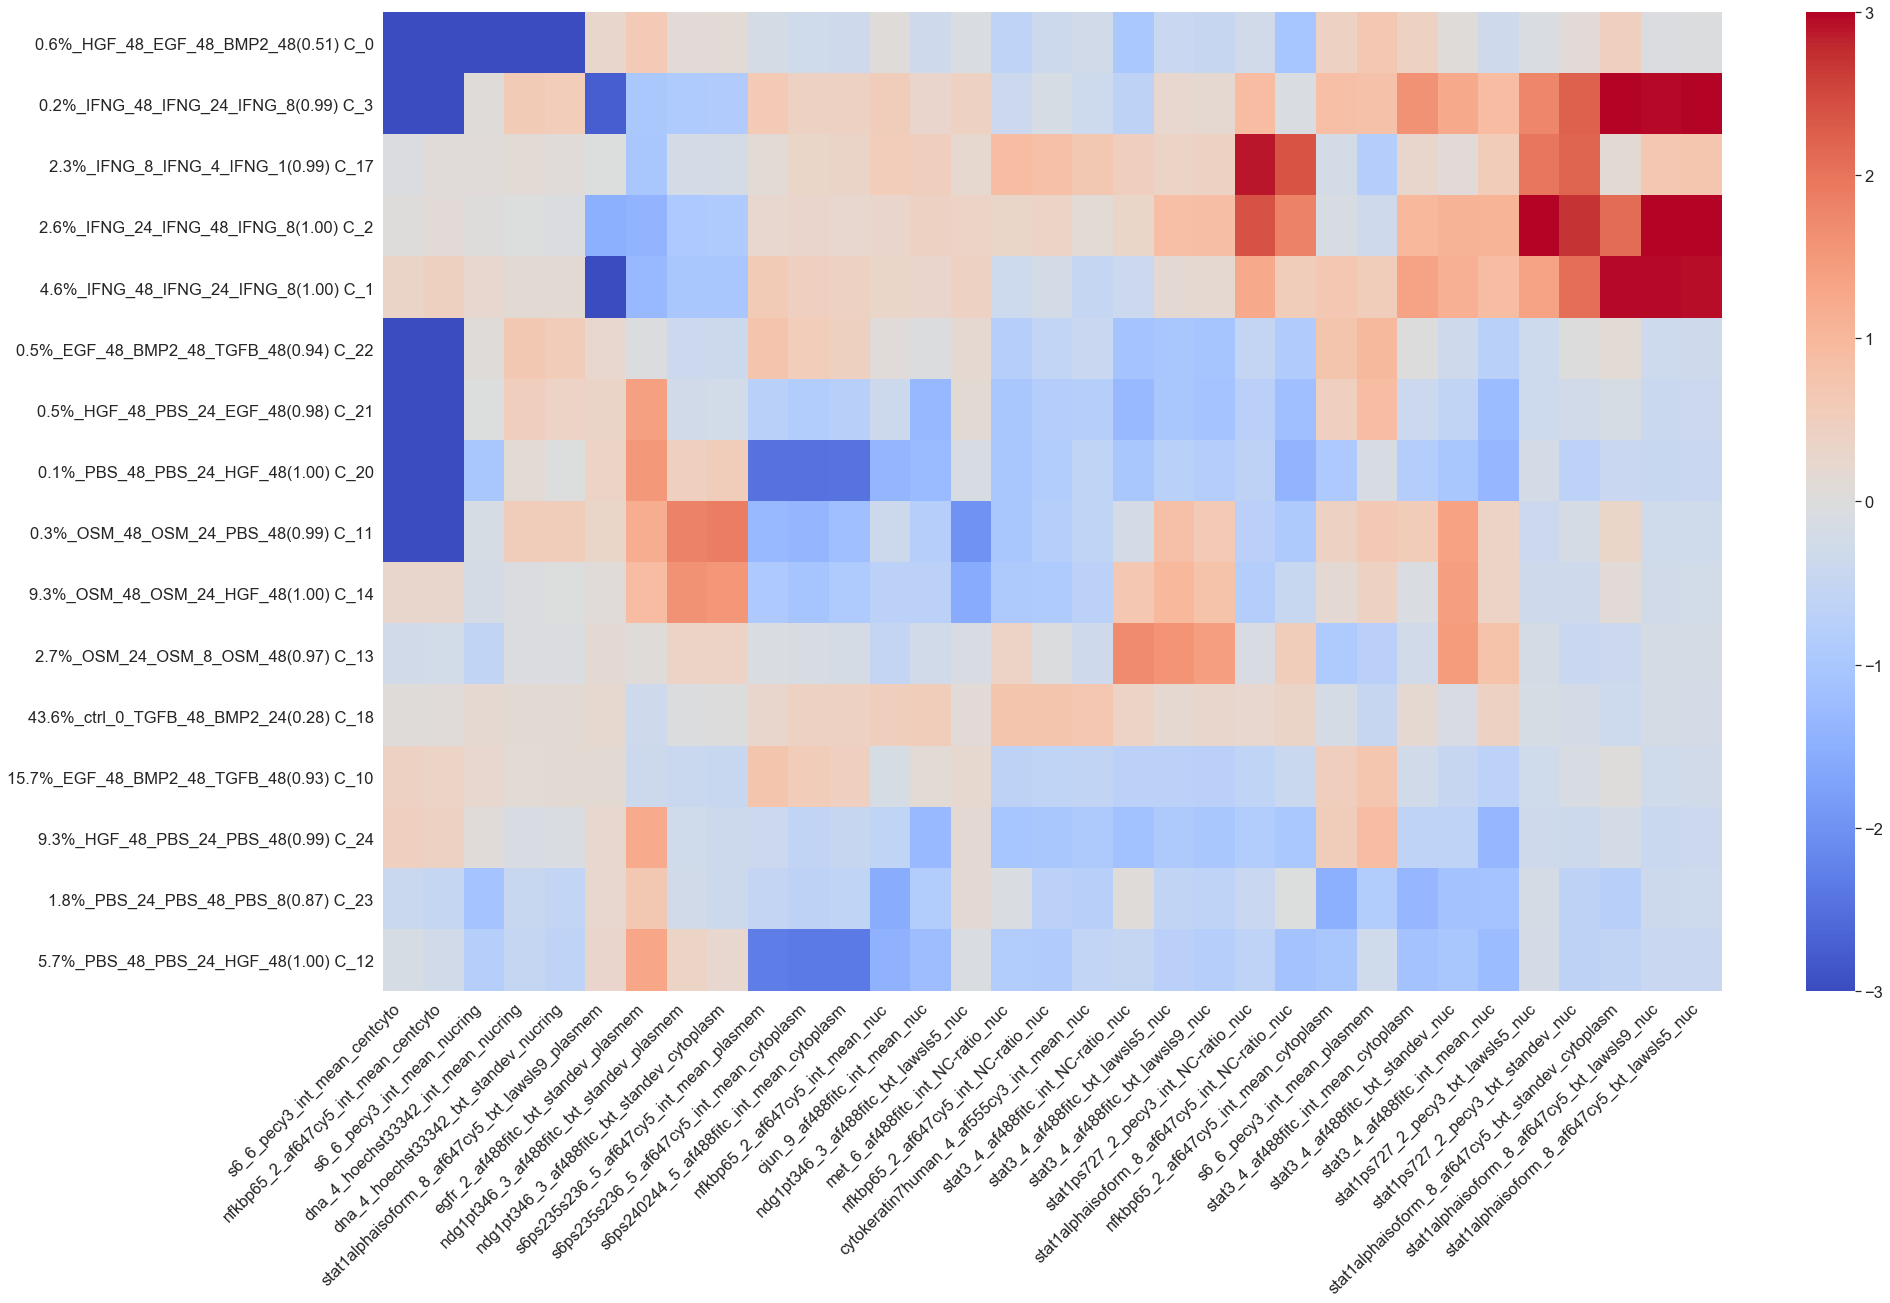

In [76]:
from sklearn.preprocessing import scale
from cycifsuite.common_apis import two_way_hc_ordering
sns.set(font_scale=1.5)
gmm_cluster_heatmap = combat_norm_data.loc[clusters.index, top_genes].groupby(clusters.values).mean()
gmm_cluster_heatmap.loc[:,:] = gmm_cluster_heatmap
r_o, c_o = two_way_hc_ordering(gmm_cluster_heatmap)
plt.figure(figsize=(30,18))
sns.heatmap(gmm_cluster_heatmap.iloc[r_o,c_o[1:]], vmin=-3, vmax=3, cmap='coolwarm',yticklabels=1, xticklabels=1)
plt.xticks(rotation=45,ha='right')
# plt.tight_layout()
# plt.savefig('umap_gmm_9_cluster_zscore.png')

## Check DNA contents of the clusters, but no real DNA content difference observed

In [53]:
dna_int = pd.read_hdf('raw_data_selected_features/pooled_expr_data_5_features.hdf').dna_4_hoechst33342_int_mean_nuc
dna_cont = dna_int*metadata.loc[dna_int.index,'area']
clusters.sort_index(inplace=True)
dna_cont.sort_index(inplace=True)
dna_cont_clusters = dna_cont[clusters.index].groupby(clusters.values).median()
dna_cont_clusters = np.log2(dna_cont_clusters)

In [82]:
print(dna_cont_clusters.sort_values())

0.3%_OSM_48_OSM_24_PBS_48(0.99) C_11       22.897279
0.1%_PBS_48_PBS_24_HGF_48(1.00) C_20       22.910124
5.7%_PBS_48_PBS_24_HGF_48(1.00) C_12       22.961738
0.5%_HGF_48_PBS_24_EGF_48(0.98) C_21       22.980561
9.3%_OSM_48_OSM_24_HGF_48(1.00) C_14       23.011155
0.6%_HGF_48_EGF_48_BMP2_48(0.51) C_0       23.072842
9.3%_HGF_48_PBS_24_PBS_48(0.99) C_24       23.073533
1.8%_PBS_24_PBS_48_PBS_8(0.87) C_23        23.175124
0.5%_EGF_48_BMP2_48_TGFB_48(0.94) C_22     23.187249
0.2%_IFNG_48_IFNG_24_IFNG_8(0.99) C_3      23.227206
15.7%_EGF_48_BMP2_48_TGFB_48(0.93) C_10    23.293582
4.6%_IFNG_48_IFNG_24_IFNG_8(1.00) C_1      23.340483
2.7%_OSM_24_OSM_8_OSM_48(0.97) C_13        23.341664
2.6%_IFNG_24_IFNG_48_IFNG_8(1.00) C_2      23.359180
2.3%_IFNG_8_IFNG_4_IFNG_1(0.99) C_17       23.436218
43.6%_ctrl_0_TGFB_48_BMP2_24(0.28) C_18    23.492172
dtype: float64
